In [2]:
# Cell 1: Imports and setup (Phase 1 inference)

import matplotlib.pyplot as plt
import torch

from thesis_ml.data.h5_loader import H5TokenDataset
from thesis_ml.utils.phase1_infer import load_model_from_run

# Change this to the run you want to inspect
run_dir = r"C:\Users\niels\Projects\Thesis-Code\Code\Niels_repo\outputs\20251021-164951"

# Load composed cfg and assembled Phase 1 model from the run directory
cfg, model, device = load_model_from_run(run_dir)
print("device:", device)
print("loaded targets:", cfg.phase1.encoder._target_, cfg.phase1.tokenizer._target_, cfg.phase1.decoder._target_)


device: cuda
loaded targets: thesis_ml.phase1.autoenc.encoders.mlp.MLPEncoder thesis_ml.phase1.autoenc.bottlenecks.vq.VQBottleneck thesis_ml.phase1.autoenc.decoders.mlp.MLPDecoder


C:\Users\niels\Projects\Thesis-Code\Code\Niels_repo\src\thesis_ml\utils\phase1_infer.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(str(weights_path

In [9]:
# Cell 2: Dataset (same normalization as training)
# Build dataset from composed cfg saved in the run dir
# (H5TokenDataset reads cfg.data.path and computes mu/sd on train split)
ds = H5TokenDataset(cfg)
val_ds = ds.get_split("val")
test_ds = ds.get_split("test")
train_ds = ds.get_split("train")

print("num val:", len(val_ds), "num test:", len(test_ds), "num train:", len(train_ds))
print("n_tokens (T):", int(cfg.data.n_tokens))
print("cont_dim:", 4, "globals:", int(cfg.data.globals.size), "num_types:", ds.num_types)

num val: 30207 num test: 30207 num train: 241658
n_tokens (T): 18
cont_dim: 4 globals: 2 num_types: 8


In [10]:
# Cell 3: Model is already loaded; confirm and print basic info
print(model.__class__.__name__)
print(sum(p.numel() for p in model.parameters()), "parameters")

BaseAutoencoder
61126 parameters


In [5]:
# Cell 4: Helper for reconstruction using unified Phase 1 model

@torch.no_grad()
def reconstruct_event(tokens_cont, tokens_id, gvec):
    # inputs are single-event tensors: [T,4], [T], [2]
    tc = tokens_cont.unsqueeze(0).to(device)  # [1,T,4]
    ti = tokens_id.unsqueeze(0).to(device)    # [1,T]
    gv = gvec.unsqueeze(0).to(device)         # [1,2]

    out = model(tc, ti, gv)
    x_hat = out["x_hat"]                     # [1,T,4] (normalized)
    perplex = float(out.get("aux", {}).get("perplex", 0.0))

    # De-normalize to original scale with train mu/sd
    mu = ds.mu[0,0].to(device)  # [4]
    sd = ds.sd[0,0].to(device)  # [4]
    tc_denorm     = tc[0] * sd + mu          # [T,4]
    x_hat_denorm  = x_hat[0] * sd + mu       # [T,4]

    return {
        "x_hat_norm": x_hat[0].cpu(),        # [T,4]
        "x_hat": x_hat_denorm.cpu(),         # [T,4] de-normalized
        "orig_norm": tc[0].cpu(),            # [T,4]
        "orig": tc_denorm.cpu(),             # [T,4] de-normalized
        "perplexity": perplex,
    }

Event 0, Token 15
Perplexity (event-level): 4.63734245300293
Original (de-normalized): [0.0000000e+00 4.7683716e-07 0.0000000e+00 0.0000000e+00]
Reconstruction (de-normalized): [ 0.04458284  0.03540039  0.00159623 -0.00090576]


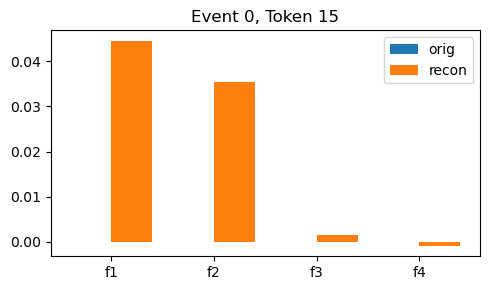

In [6]:
# Cell 5: Pick an event and a token index, then visualize
event_idx = 0     # change this to inspect a different event from the test set
token_idx = 15     # 0..T-1 (e.g., 0..17)

tokens_cont, tokens_id, gvec = test_ds[event_idx]
out = reconstruct_event(tokens_cont, tokens_id, gvec)

orig = out["orig"][token_idx]     # [4]
recon = out["x_hat"][token_idx]   # [4]

print(f"Event {event_idx}, Token {token_idx}")
print("Perplexity (event-level):", out["perplexity"])
print("Original (de-normalized):", orig.numpy())
print("Reconstruction (de-normalized):", recon.numpy())

# Simple bar comparison
feature_names = ["f1","f2","f3","f4"]  # replace with actual names if you have them
x = range(4)
plt.figure(figsize=(5,3))
plt.bar([i-0.2 for i in x], orig,  width=0.4, label="orig")
plt.bar([i+0.2 for i in x], recon, width=0.4, label="recon")
plt.xticks(x, feature_names)
plt.title(f"Event {event_idx}, Token {token_idx}")
plt.legend()
plt.tight_layout()
plt.show()

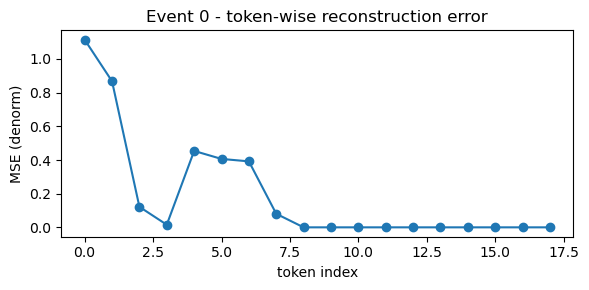

In [7]:
import torch

# Cell 6 (optional): Inspect all tokens for an event at once
event_idx = 0
tokens_cont, tokens_id, gvec = test_ds[event_idx]
out = reconstruct_event(tokens_cont, tokens_id, gvec)

# L2 error per token (on de-normalized features)


per_token_mse = ((out["orig"] - out["x_hat"])**2).mean(dim=1)  # [T]
plt.figure(figsize=(6,3))
plt.plot(per_token_mse.numpy(), marker="o")
plt.xlabel("token index")
plt.ylabel("MSE (denorm)")
plt.title(f"Event {event_idx} - token-wise reconstruction error")
plt.tight_layout()
plt.show()

In [ ]:
# Cell 7 (optional, requires ipywidgets): interactive browsing
# pip install ipywidgets if needed; in JupyterLab enable the extension
try:
    import ipywidgets as widgets
    from IPython.display import clear_output, display

    T = int(cfg.data.n_tokens)
    def show(event_idx=0, token_idx=0):
        tokens_cont, tokens_id, gvec = test_ds[event_idx]
        out = reconstruct_event(tokens_cont, tokens_id, gvec)
        orig = out["orig"][token_idx]
        recon = out["x_hat"][token_idx]

        clear_output(wait=True)
        print(f"Event {event_idx}, Token {token_idx} | Perplexity: {out['perplexity']:.3f}")
        x = range(4)
        plt.figure(figsize=(5,3))
        plt.bar([i-0.2 for i in x], orig,  width=0.4, label="orig")
        plt.bar([i+0.2 for i in x], recon, width=0.4, label="recon")
        plt.xticks(x, ["f1","f2","f3","f4"])
        plt.legend()
        plt.tight_layout()
        plt.show()

    w_event = widgets.IntSlider(value=0, min=0, max=len(test_ds)-1, step=1, description="event")
    w_token = widgets.IntSlider(value=0, min=0, max=T-1, step=1, description="token")

    ui = widgets.VBox([w_event, w_token])
    out_area = widgets.interactive_output(show, {"event_idx": w_event, "token_idx": w_token})
    display(ui, out_area)
except Exception as e:
    print("ipywidgets not available:", e)

Output()